In [1]:
from unet_seg import UNet
from data_loader import UltrasoundDatasetSeg, BratsDatasetSeg
import torch
import matplotlib.pyplot as plt

import numpy as np
import os
import shutil
from torchvision.utils import save_image
from torch.utils.data import DataLoader, random_split, Subset
import warnings

/home/camp/anaconda3/envs/diffusion/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_dice_score(diff_truth, diff_pred):
    if diff_truth.sum() == 0 and diff_pred.sum() == 0:
        return 1.0
    dice_score = 2 * (diff_truth & diff_pred).sum() / (diff_truth.sum() + diff_pred.sum())
    return round(dice_score, 4)


def get_iou_score(diff_truth, diff_pred):
    if diff_truth.sum() == 0 and diff_pred.sum() == 0:
        return 1.0
    intersection = np.logical_and(diff_truth, diff_pred)
    union = np.logical_or(diff_truth, diff_pred)
    iou_score = np.sum(intersection) / np.sum(union)
    return round(iou_score, 4)

def get_precision_score(diff_truth, diff_pred):
    if diff_truth.sum() == 0 and diff_pred.sum() == 0:
        return 1.0
    true_positives = np.sum(diff_truth & diff_pred)
    false_positives = np.sum(diff_pred) - true_positives
    if true_positives + false_positives != 0:
        precision_score = true_positives / (true_positives + false_positives)
    else:
        precision_score = 0.0
    return round(precision_score, 4)


def get_recall_score(diff_truth, diff_pred):
    if diff_truth.sum() == 0 and diff_pred.sum() == 0:
        return 1.0
    true_positives = np.sum(diff_truth & diff_pred)
    false_negatives = np.sum(diff_truth) - true_positives
    if true_positives + false_negatives != 0:
        recall_score = true_positives / (true_positives + false_negatives)
    else:
        recall_score = 0.0
    return round(recall_score, 4)


def get_fpr_score(diff_truth, diff_pred):
    false_positives = np.sum(diff_pred) - np.sum(diff_truth & diff_pred)
    true_negatives = np.sum(~diff_truth & ~diff_pred)
    try:
        fpr_score = false_positives / (false_positives + true_negatives)
    except:
        fpr_score = 0.0
    return round(fpr_score, 4)


def get_auprc_score(diff_truth, diff_pred):
    warnings.filterwarnings("ignore", message="No positive class found in y_true*")
    precision, recall, thresholds = precision_recall_curve(diff_truth.flatten(), diff_pred.flatten())
    auprc = auc(recall, precision)
    return round(auprc, 4)


def get_hausdorff_distance(diff_truth, diff_pred, percentile=95):
    from scipy.spatial import distance
    # Compute all pairwise distances
    dists = distance.cdist(diff_truth, diff_pred, 'euclidean')

    # Compute directed Hausdorff distances
    distance_1 = np.min(dists, axis=1)
    distance_2 = np.min(dists, axis=0)

    # Find the percentile distance
    hd1 = np.percentile(distance_1, percentile)
    hd2 = np.percentile(distance_2, percentile)

    return round(max(hd1, hd2), 4)


def get_ssim_score(x_0, x_pred):
    from skimage.metrics import structural_similarity as ssim
    x_0_array = x_0.cpu().detach().numpy().squeeze()
    x_pred_array = x_pred.cpu().detach().numpy().squeeze()
    ssim_score = ssim(x_0_array, x_pred_array, data_range=x_0_array.max() - x_0_array.min())
    return round(ssim_score, 4)

In [3]:
def write_log_file(file_path,txt):
    with open(file_path, 'a') as f:
        f.write(txt + '\n')

In [10]:
# pretrained_path = '../output/LiTS/seg_model/brats_model_best.pth'
# img_file = '../output/LiTS/test_anomalous_abdomen_dataset.pkl'
# label_file = '../output/LiTS/test_anomalous_tumor_masks.pkl'
# test_dataset = UltrasoundDatasetSeg(img_file, label_file,128,False)

# pretrained_path = '../output/Ultrasound/seg_model/brats_model_best.pth'
# img_file = '../output/Ultrasound/test_anomalous_dataset.pkl'
# label_file = '../output/Ultrasound/test_anomalous_masks.pkl'
# test_dataset = UltrasoundDatasetSeg(img_file, label_file,128,False)

pretrained_path = '../output/BraTS/seg_model/brats_model_best.pth'
img_file = '../output/BraTS/test_anomalous_dataset.npy'
label_file = '../output/BraTS/test_anomalous_masks.npy'
test_dataset = BratsDatasetSeg(img_file, label_file,128,False)

log_path = os.path.join(os.path.dirname(pretrained_path),'log.txt')

model = UNet(init_features=64).to('cuda')
checkpoint = torch.load(pretrained_path)
model.load_state_dict(checkpoint["state_dict"])
print(checkpoint['epoch'])

model.eval()



num_test_data = int(len(test_dataset) * 0.5)

test_dataset = Subset(test_dataset, list(range(num_test_data, len(test_dataset))))

test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)
evaluation_score_list=[]
for i, image in enumerate(test_dataloader):
    with torch.no_grad():
        x_0 = image[0].to('cuda')
        x_pred = model(x_0)

    predicted_anomaly = x_pred.cpu().squeeze().numpy()
    predicted_anomaly[predicted_anomaly < 0.5] = 0
        
    groundtruth_anomaly = image[1].cpu().squeeze().numpy().astype(bool)
    predicted_anomaly = predicted_anomaly.astype(bool)

    evaluation_scores = {
        "dice_score": get_dice_score(groundtruth_anomaly, predicted_anomaly),
        "iou_score": get_iou_score(groundtruth_anomaly, predicted_anomaly),
        "precision_score": get_precision_score(groundtruth_anomaly, predicted_anomaly),
        "recall_score": get_recall_score(groundtruth_anomaly, predicted_anomaly),
        "hausdorff_score": get_hausdorff_distance(groundtruth_anomaly, predicted_anomaly),
        "ssim_score": get_ssim_score(x_0, x_pred)
    }
    evaluation_score_list.append(evaluation_scores)

score_names = list(evaluation_score_list[0].keys())
evaluation_mean = {score_name: round(np.mean([entry[score_name] for entry in evaluation_score_list]), 4) for score_name in score_names}
evaluation_std = {score_name: round(np.std([entry[score_name] for entry in evaluation_score_list]), 4) for score_name in score_names}

print(f"Average DICE score: {evaluation_mean['dice_score']}+-{evaluation_std['dice_score']}, average IOU score: {evaluation_mean['iou_score']}+-{evaluation_std['iou_score']}, average Precision: {evaluation_mean['precision_score']}+-{evaluation_std['precision_score']}, average Recall: {evaluation_mean['recall_score']}+-{evaluation_std['recall_score']}, average Hausdorff: {evaluation_mean['hausdorff_score']}+-{evaluation_std['hausdorff_score']}, average SSIM: {evaluation_mean['ssim_score']}+-{evaluation_std['ssim_score']}")
write_log_file(log_path,f"Average DICE score: {evaluation_mean['dice_score']}+-{evaluation_std['dice_score']}, average IOU score: {evaluation_mean['iou_score']}+-{evaluation_std['iou_score']}, average Precision: {evaluation_mean['precision_score']}+-{evaluation_std['precision_score']}, average Recall: {evaluation_mean['recall_score']}+-{evaluation_std['recall_score']}, average Hausdorff: {evaluation_mean['hausdorff_score']}+-{evaluation_std['hausdorff_score']}, average SSIM: {evaluation_mean['ssim_score']}+-{evaluation_std['ssim_score']}")



196
Average DICE score: 0.8275+-0.2229, average IOU score: 0.7504+-0.2393, average Precision: 0.8499+-0.2372, average Recall: 0.8495+-0.2167, average Hausdorff: 1.8413+-0.8937, average SSIM: 0.6405+-0.0307


In [10]:
print(i)

0


In [12]:
np.unique(groundtruth_anomaly_mask)

array([0., 1.], dtype=float32)

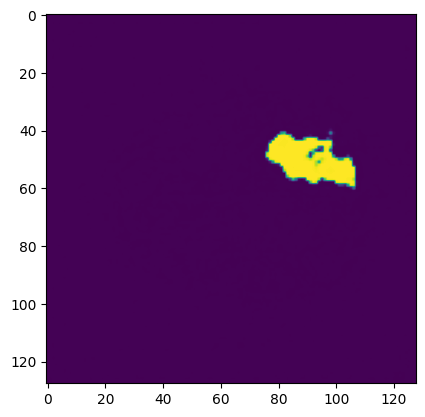

In [34]:
plt.imshow(x_pred.cpu().squeeze().numpy())

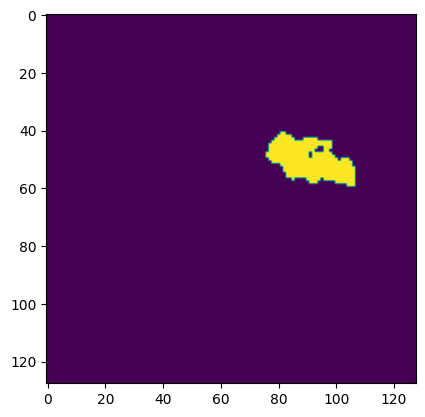

In [35]:
plt.imshow(predicted_anomaly)